# Titanic predictions
This notebook gives an example application of the decision tree classifier. The titanic dataset documents a number of attributes related to passengers of the famous Titanic voyage. We will try to use these attributes to predict whether a passenger died or survived from the titanic dataset.

Dataset can be donwloaded from [here](https://www.kaggle.com/c/titanic/data).

We will also compare the performance of our implementation of a decision tree classifier to an open-source implementation from sci-kit learn.

In [1]:
import pandas as pd

## Calling C++ directly from Python
Compiled C and C++ libraries can be directly interfaced and called from Python. The cell below interfaces our C++ decision tree classifier into Python so we can call it directly from this notebook.

In [2]:
# create wrapper to call C++ library directly from Python
import ctypes
import pathlib

def cpp_decision_tree(trainPath, testPath):
    # Load the shared library into ctypes
    libname = pathlib.Path().absolute() / "../build/libDecisionTree.dylib"

    c_lib = ctypes.CDLL(libname)
    decisionTree = c_lib.decisionTree

    # response type is a integer pointer
    decisionTree.restype = ctypes.POINTER(ctypes.c_int)

    # argument types are pointers to characters
    decisionTree.argtypes = [ctypes.c_char_p, ctypes.c_char_p]


    with open(testPath) as f:
        first_line = f.readline()
    number_predictions = first_line.count(',') + 1
    
    decisionTreeP = decisionTree(trainPath.encode('utf-8'), testPath.encode('utf-8'))

    # parsing predictions into a list for Python
    predictions = [decisionTreeP[i] for i in range(number_predictions)]
    
    return predictions

## Preparing dataset for training classifier

In [3]:
train = pd.read_csv('titanic/train.csv')

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


As the decision tree classifier was only implemented to handle categorical features, we select only the categorical features from our dataset.

In [5]:
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
target_variable = 'Survived'

In [6]:
# convert to categorical types
train = train[categorical_features + [target_variable]].astype('category')

In [7]:
train.Embarked = train.Embarked.cat.add_categories("NaN").fillna("NaN")

In [8]:
train_enc = train.copy()

We numerically encode our categories to integers to be compatible with the C++ library implementation.

In [9]:
# numerically encode categorical features
for col in train_enc.columns:
    train_enc[col] = train_enc[col].cat.codes

In [10]:
for col in train.columns:
    print(train[col].cat.categories)

Int64Index([1, 2, 3], dtype='int64')
Index(['female', 'male'], dtype='object')
Int64Index([0, 1, 2, 3, 4, 5, 8], dtype='int64')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Index(['C', 'Q', 'S', 'NaN'], dtype='object')
Int64Index([0, 1], dtype='int64')


In [11]:
# check category labels are compatible with C++ library
for col in train_enc.columns:
    print(train_enc[col].unique())

[2 0 1]
[1 0]
[1 0 3 4 2 5 6]
[0 1 2 5 3 4 6]
[2 0 1 3]
[0 1]


Split data into train and test sets to enable evaluation of model against true values.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test = train_test_split(train_enc, random_state=1)

In [14]:
# need to transpose to be compatible with C++ library
X_train.T.to_csv("../test/resources/titanicTrain.csv", header=False, index=False)

In [15]:
# remove outcomes from test
X_test.drop(columns='Survived').T.to_csv("../test/resources/titanicTest.csv", header=False, index=False)

In [16]:
X_test.Survived

862    1
223    0
84     1
680    0
535    1
      ..
506    1
467    0
740    1
354    0
449    1
Name: Survived, Length: 223, dtype: int8

In [17]:
# read data csvs into C++ library and return predictions
predictions = cpp_decision_tree("../test/resources/titanicTrain.csv", "../test/resources/titanicTest.csv")

In [18]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

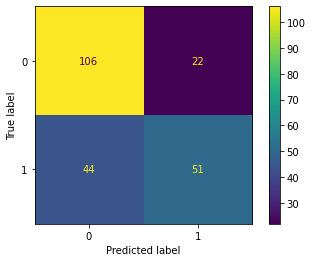

In [19]:
ConfusionMatrixDisplay(confusion_matrix(X_test.Survived, predictions)).plot()

## Compare with open-source decision tree implementation
Compare to scikit-learn decision tree classifier

In [20]:
# compare using sklearn decision tree
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier()

In [22]:
clf = clf.fit(X_train.drop(columns='Survived'), X_train.Survived)

In [23]:
sklearn_predictions = clf.predict(X_test.drop(columns='Survived'))

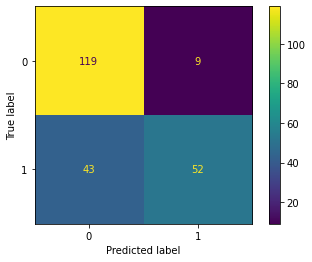

In [24]:
ConfusionMatrixDisplay(confusion_matrix(X_test.Survived, sklearn_predictions)).plot()

In [25]:
import numpy as np

In [26]:
# calculate mean absolute error between C++ implementation of classifier and SK-learn
MAE = np.sum(np.abs(sklearn_predictions - predictions)) / len(predictions)

In [27]:
MAE

0.14349775784753363

## Results
We see 0.14 mean absolute error between the scikit-learn implementation and our own C++ implementation. We would expect the default settings for the SK-learn classifier to give the same results as our implementation of the classifier on this dataset, so likely there are some bugs in our implementation or we are misinterpreting the SK-learn docs. We aren't too far off with 85% of predictions from each classifier giving the same label.